# Automated Brest Cancer Prediciton with Machine Learning & Deep Learning 
# --> Accuracy = 98,24 %
##### Pierre-Louis Danieau

# 1. Introduction

The objective of this study is to automatically detect if a breast tumor is malignant or benign. 

A tumor is said to be malignant if the patient has a cluster of cancerous cells whereas a benign tumor is not a cancer and is therefore much easier to treat.

Thanks to a Fine Needle Aspiration (FNA) which is a surgical diagnostic method that involves taking cells and tissue from nodules of the breast tumor, it is possible to analyze tumor samples like these under the microscope :

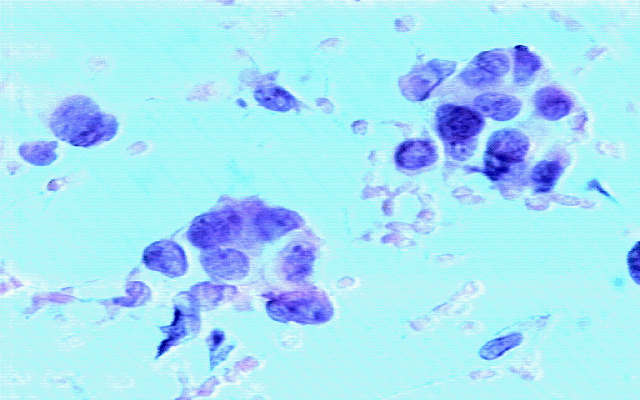

            Example of fine needle aspiration samples from a breast mass
            
            

Many specialists such as medical doctors and computer engineers (*Dr. William H. Wolberg, W. Nick Street, Olvi L. Mangasarian*) have developed a whole process which, from digitized images of hundreds of tumors like those shown above, makes it possible to determine a whole set of characteristics describing each of the cells of the tumor.  

These methods are very well explained in [K. P. Bennett and O. L. Mangasarian: "Robust Linear Programming Discrimination of Two Linearly Inseparable Sets"] available [here](https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.23.3307&rep=rep1&type=pdf).

With the work of all these researchers, it is possible to determine automatically ten real-valued features for each cell nucleus in the 3-dimensional space. 

We thus obtain 3 groups : Mean, Standard Error and Worst values of 10 characteristics each associated with the doctors' diagnosis (Malignant or Benign).

These 10 features represent geometric characteristics of the cells, they include for example:

* 1) radius (mean of distances from center to points on the perimeter)
* 2) texture (standard deviation of gray-scale values)
* 3) perimeter
* 4) area
* 5) smoothness (local variation in radius lengths)
* 6) compactness (perimeter^2 / area - 1.0)
* 7) concavity (severity of concave portions of the contour)
* 8) concave points (number of concave portions of the contour)
* 9) symmetry
* 10) fractal dimension ("coastline approximation" - 1)

## *My work* :  From these 30 characteristics realize an algorithm that predicts if a tumor is cancerous or not.

# 2. Loading packages + Data Reading

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# here we will import the libraries used for machine learning
import numpy as np # linear algebra
import pandas as pd # data processing, data manipulation as in SQL
import matplotlib.pyplot as plt # this is used for the plot the graph 
import seaborn as sns # used for plot interactive graph
%matplotlib inline
from sklearn.linear_model import LogisticRegression # Logistic regression model
from sklearn.model_selection import train_test_split # to split the data into training and test set
from sklearn.model_selection import KFold # use for cross validation
from sklearn.model_selection import GridSearchCV# for tuning parameter of models
from sklearn.ensemble import RandomForestClassifier # for random forest classifier model
from sklearn.neighbors import KNeighborsClassifier # for K Neighbors model
from sklearn.tree import DecisionTreeClassifier # for Decision Tree model
from sklearn import svm # for Support Vector Machine model
from sklearn import metrics # for the check the error and accuracy of the model

### Read Data direclty on Kaggle but also available here : https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29 ###
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

data=pd.read_csv('/kaggle/input/breast-cancer-wisconsin-data/data.csv') # import from a csv file
data.drop("Unnamed: 32",axis=1,inplace=True) # delete unnecessary columns

#### transform the problem into binary classification : Malignant = 1 ans Benign = 0 ###
data['diagnosis']=data['diagnosis'].map({'M':1,'B':0}) 
data.head(10) # show data

In [ ]:
# As I said above the data can be divided into three parts corresponding to 3 dimensional features '(mean, se, worst)' 
# computed with the  the 3 dimensonial values (X,Y,Z)

features_mean= list(data.columns[2:12]) # mean group
features_se= list(data.columns[12:22]) # standard error group
features_worst=list(data.columns[22:32]) # features_worst group

print("-----------------------------------")
print('Mean set of all features')
print(features_mean)
print(len(features_mean), 'features')
print("-----------------------------------")
print('Standard Error set of all features')
print(features_se)
print(len(features_se), 'features')
print("------------------------------------")
print('Worst set of all features')
print(features_worst)
print(len(features_worst), 'features')
print(' ')
print('Description of data columns')
data.iloc[:,1:].describe() # description of all columns in the dataset (30 features + diagnosis)

# 3. Data Analysis

* ### Study of the correlations between the 10 variables of the 3 groups. 
* ### The darker a box is, the more the 2 associated features are correlated.

In [ ]:
sns.heatmap(data[features_mean].corr(),annot=True,cmap='Blues')

In [ ]:
sns.heatmap(data[features_se].corr(),annot=True,cmap='Blues')

In [ ]:
sns.heatmap(data[features_worst].corr(),annot=True,cmap='Blues')

* ###  Correlation conclusion : 

The dark blue boxes are those associated with two highly correlated features. 

It is therefore possible to delete some of them which do not bring any added value to our data set.

* The features 'radius', 'perimeter' and 'area' are strongly correlated, which is not surprising given the geometrical relationship by which they are linked. I decide to keep only the 'perimeter' variable.

* Also, the variables 'compactness', 'concavity' and 'concavepoint' are strongly correlated so we will only use 'compactness_mean', 'compactness_se' and 'compactness_worst' in our case. 

In [ ]:
#####  delete features higly corrolated described above  ###########

col_to_drop_corrolated1=['radius_mean','radius_se','radius_worst','area_mean','area_se','area_worst']
col_to_drop_corrolated2=['concavity_mean','concave points_mean', 'concavity_se','concave points_se' ,'concavity_worst','concave points_worst']
data.drop(col_to_drop_corrolated1+col_to_drop_corrolated2,axis=1,inplace=True)
print('I keep only ', len(data.columns) ,' features which are not so corrolated based on the previous analysis')

* ### Univariate analysis on each features to discover those which allow to discretize the variable 'diagnosis'.

In [ ]:
predict = data.diagnosis.unique() # unique values from diagnosis features : 1 and 0
predict_n=['Malin', 'Benin'] # labels

fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(15,25)) # axis configuration : 18 features on 6 * 3 charts
i=0
axes = axes.ravel()
for idx,ax in enumerate(axes): # for each chart
    col=data.columns[i+2]
    i=i+1
    ax.hist([data.loc[data.diagnosis == x, col] for x in predict], label=predict_n, bins=25,stacked=False, alpha=0.7,color=['r','b'], histtype='step') # plot the feature histogram 
    ax.legend(loc='upper right') # legend of each chart
    ax.set_title(col) # title

plt.show() # show the 18 charts

* ### Univariate analysis conclusion :

We can see that some variables allow more easily than others to discriminate between cancerous and healthy cells. 

For example the variables: "compactness_mean", "compactness_worst" or "perimeter mean" have a big influence on the final prediction compared to other variables such as "fractal_dimension_mean", "symmetry mean", "smoothness mean" or "texture_mean".

We will therefore remove these features because they do not allow us to determine if a tumor is cancerous or not.

This choice is obviously questionable but the objective is to simplify the input data as much as possible to have a better understanding of the underlying algorithms.


* ### Delete features based on the above analysis

In [ ]:
col_to_drop_mean=['fractal_dimension_mean', 'symmetry_mean', 'smoothness_mean', 'texture_mean'] # mean variables not efficient for detection
col_to_drop_se=['fractal_dimension_se', 'symmetry_se', 'smoothness_se', 'texture_se'] # Standard error variables not efficient for detection
col_to_drop_worst=['fractal_dimension_worst'] # Worst variable not efficient for detection
col_to_drop_tot=col_to_drop_mean+col_to_drop_se+col_to_drop_worst
data.drop(col_to_drop_tot,axis=1,inplace=True)
print('Now the data set is only composed of ', len(data.columns), 'features')

* ### Study of the correlation on the remaining features (to verify the quality of previous work)

In [ ]:
color_function = {0: "blue", 1: "red"} # Here Red color will be 1 which means M and blue foo 0 means B
colors = data["diagnosis"].map(lambda x: color_function.get(x))# mapping the color fuction with diagnosis column
pd.plotting.scatter_matrix(data.iloc[:,2:], c=colors, alpha = 0.5, figsize = (15, 15)); # plotting scatter plot matrix

Most of the remaining features are now poorly correlated with each other, except perhaps for a few exceptions in the "texture" variables. 

The general idea is to get good results while facilitating the analysis.

* ### Conclusion on features selection :

In [ ]:
print('The most important final features for breast cancer detection are : ')
list(data.columns.values[2:])

In concrete terms, the main characteristics of a cell that allow us to predict whether or not it is cancerous are : 

* the **perimeter**, 
* the **symmetry**, 
* the **compactness**, 
* the **smoothness**. 

# 4. Machine Learning Algorithm

* ## Main goal of this part : Apply Machine Learning Algorithms on the above data in order to detect cancerous cells.

    * ### I start trying 4 algorithms : DecisionTree, SVM, K-Nearest Neighbors (KNN), RandomForestClassifier.

    * ### Then, I compute the scores with Cross Validation and I select the one that maximizes accuracies

In [ ]:
######## Classification model fonction that apply each above algortihm to the data and compute the scores on each fold of the cross validation   ###########

from sklearn.preprocessing import StandardScaler # To norm the data

train, test = train_test_split(data, test_size = 0.3)# main data is splitted into train and test set

# As we are going to use many models lets make a function which we can use with different models
def classification_model(model,data,prediction_input,output):
   
    """ 
    paramters:
        model : name of the model tested (Decision Tree, SVM, KNN, RandomForest), sklearn object.
        data : Main dataframe of all data, pandas dataframe.
        prediction_input : name of the prediction variables, in our case it is the 9 features described above, list(str).
        output : name of target variable, in our case it is the diagnosis feature, str.
        
    return:
        None 
        (print accuracy and cross validation score of each models)
    """
    

    #Fit the model:
    train, test = train_test_split(data, test_size = 0.3) # in this our main data is splitted into train (70%) and test (30%) into the function (local variables)
    train_X = train[prediction_input] # taking the training data input 
    train_y=train.diagnosis # This is output of our training data
    
    # same for data test
    test_X= test[prediction_input] # taking test data inputs
    test_y =test.diagnosis   #output value of test data
    
    # norm the data with mean of 0 and standard deviation of 1
    sc = StandardScaler() # sklearn object
    sc.fit_transform(data[prediction_input]) 
    train_X = sc.transform(train_X) #transform train set with the scaler method
    test_X = sc.transform(test_X) # transform test set with scaler method
    
    model.fit(train_X,train_y) #Here we fit the model using training set
  
    #Make predictions on test set:
    predictions = model.predict(test_X)
  
    # Check accuracy 
    accuracy = metrics.accuracy_score(predictions,test_y)
    print("Accuracy on test set : %s" % "{0:.3%}".format(accuracy))
 
    # Cross validation on 5 random folds 
    kf = KFold(n_splits=5)
    
    error = []
    print(kf)
    print('  ')
    
    # For each folds, we fit the model and compute the accuracy, to prevent overfitting
    for train, test in kf.split(data):
        # as the data is divided into train and test using KFold
        # so here also we are going to fit model
        #in the cross validation the data in train and test will change for evry iteration
        train_X = (data[prediction_input].iloc[train,:])# this iloc method is used for selecting trainig data
        train_y = data[output].iloc[train]# here is only column so it repersenting only row in train
        
        train_X = sc.transform(train_X) # Scale the train data
        
        # Training the algorithm using the predictors and target.
        model.fit(train_X, train_y)
    
        # now do this for test data also
        test_X=data[prediction_input].iloc[test,:]
        test_y=data[output].iloc[test]
        test_X = sc.transform(test_X)
        
        # compute the score on test set
        error.append(model.score(test_X,test_y))
        
        # printing the score 
        print("Cross-Validation Score : %s" % "{0:.3%}".format(np.mean(error)))




* ### Try on differents models :

* ###  Decision Tree Classifier 

In [ ]:
model = DecisionTreeClassifier()
prediction_var=data.columns[2:]
outcome_var= "diagnosis"
classification_model(model,data,prediction_var,outcome_var)

* ###  SVM

In [ ]:
model = svm.SVC()
classification_model(model,data,prediction_var,outcome_var)

* ###  KNN

In [ ]:
model = KNeighborsClassifier()
classification_model(model,data,prediction_var,outcome_var)

* ###  RandomForest Classifier 

In [ ]:
model = RandomForestClassifier(n_estimators=100)
classification_model(model,data,prediction_var,outcome_var)

### The best model seems to be the SVM classifier. So let's optimize it with a Grid Search CV to tune hyperparameter.

In [ ]:
# lets Make a function for Grid Search CV
def Classification_model_gridsearchCV(model,param_grid,data_X,data_y):
    
    """
    parameter :
        model : model we want to tune. In our case it is SVM classifier.
        paramg_grid : dictionnary of all hyperparameters of the model we want to optimize
        data_X : train features data
        data_y : train prediciton data
        
    return :
        None 
        (print the best parameters and estimator associated with the scores)
    
    """
    clf = GridSearchCV(model,param_grid,cv=10,scoring="accuracy")
    # this is how we use grid serch CV we are giving our model : we gave parameters those we want to tune
    # Cv is for cross validation
    
    # Fit all models with all hyperparameter configuration
    clf.fit(train_X,train_y)
    print("The best parameter found on development set is :")
    
    # this will gie us our best parameter to use
    print(clf.best_params_)
    print("the best estimator is ")
    print(clf.best_estimator_)
    print("The best score is ")
    
    # this is the best score that we can achieve using these parameters
    print(clf.best_score_*100, '%')

In [ ]:
#now split our data into train and test
train, test = train_test_split(data, test_size = 0.3)# in this our main data is splitted into train and test

train_X = train[prediction_var]# taking the training data input 
train_y=train.diagnosis# This is output of our training data

# same for test set
test_X= test[prediction_var] # taking test data inputs
test_y =test.diagnosis   #output value of test data

# scale data
sc = StandardScaler()
sc.fit_transform(data[prediction_var])
train_X = sc.transform(train_X)
test_X = sc.transform(test_X)

# Here we have to take parameters that are used for SVM Classifier
    # C: Regularization parameter. The strength of the regularization is inversely proportional to C. 
    # kernel : Specifies the kernel type to be used in the algorithm.

param_grid = {'C': [0.65,0.75,0.8,1], 
              'kernel': [ 'linear','poly','rbf','sigmoid'],
                }
# here our gridasearchCV will take all combinations of these parameter and apply it to model 
# and then it will find the best parameter for model
model= svm.SVC()
Classification_model_gridsearchCV(model,param_grid,train_X,train_y) # call the function

# 5. Machine Learning Conclusion

* ### The best Machine Learning model tested is : SVM (C = 0.65, kernel = 'rbf')
* ### Let's compute some metrics with this model : (precision, recall, F1-score), confusion matrix and ROC curve

In [ ]:
model=svm.SVC(C=0.65, kernel='rbf')# our best classifier
model.fit(train_X,train_y)# now fit our model for traiing data
prediction=model.predict(test_X)# predict for the test data

# here we use accuracy measurement between our predicted value and our test output values
print('------------------------')
print('Accuracy score : ', metrics.accuracy_score(prediction,test_y)*100, ' %') # to check the accuracy
print('------------------------')

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Precision quantifies the number of positive class predictions that actually belong to the positive class.
precision = precision_score(test_y, prediction, average='binary')

# Recall quantifies the number of positive class predictions made out of all positive examples in the dataset.
recall = recall_score(test_y, prediction, average='binary')

# F-Measure provides a single score that balances both the concerns of precision and recall.
score = f1_score(test_y, prediction, average='binary')

print('Precision : ',precision *100 ,' %')
print('------------------------')
print('Recall : ' ,recall*100 ,' %') # Best score to considerate in our case beacause Recall is appropriate when minimizing False Negatives. 
print('------------------------')
print('F1_score : ', score*100 ,' %')

### The best score to considerate is the **Recall** because in cancer detetcion we want to minimize False Negatives (e.g : prediction of a non-cancerous tumor when it is) 

In [ ]:
#### Plotting confusion matrix   ######

from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(model, test_X, test_y)
plt.title('Confusion Matrix')
metrics.plot_roc_curve(model, test_X, test_y) 
plt.title('ROC Curve')
plt.show()

* ### Summary Machine Learning
    * #### Good accuracy with only 9 features : 98.24% (We make the right prediction in 98.24% of the cases)
    
    * #### Good Recall : 96.77 % but it is not 100% so we do not detect all cancerous tumor ! It is very problematic !
    * #### So, the main problem is that a cancerous tumor is not detected in all cases. ( X patients are not detected as having a cancerous tumor : Value at the bottom left in the confusion matrix).
    * #### Let's see with Deep Learing methods if we can decrease the number of cancerous cells non-detected

# 6. Simple Deep Learning Algorithm (DNN)

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout

classifier = Sequential()

# Adding the input layer and the first hidden layer
classifier.add(Dense(16 , activation='relu', input_dim=9))
# Adding dropout to prevent overfitting
classifier.add(Dropout(rate=0.1))

# Adding the second hidden layer
classifier.add(Dense(16, activation='relu'))
# Adding dropout to prevent overfitting
classifier.add(Dropout(rate=0.1))

# Adding the output layer
classifier.add(Dense(1, activation='sigmoid'))

# Compiling the ANN
classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#Optimizer is chosen as adam for gradient descent and Binary_crossentropy is the loss function used.

# Fitting the ANN to the Training set
classifier.fit(train_X, train_y, batch_size=75, epochs=120)
# Long scroll ahead but worth
# The batch size and number of epochs have been set using trial and error. Still looking for more efficient ways. Open to suggestions.

y_pred = classifier.predict(test_X)
y_pred = (y_pred > 0.5)

In [ ]:
# Precision quantifies the number of positive class predictions that actually belong to the positive class.
precision = precision_score(test_y, y_pred, average='binary')

# Recall quantifies the number of positive class predictions made out of all positive examples in the dataset.
recall = recall_score(test_y, y_pred, average='binary')

# F-Measure provides a single score that balances both the concerns of precision and recall.
score = f1_score(test_y, y_pred, average='binary')

print('Precision : ',precision *100 ,' %')
print('------------------------')
print('Recall : ' ,recall*100 ,' %') # Best score to considerate in our case beacause Recall is appropriate when minimizing False Negatives. 
print('------------------------')
print('F1_score : ', score*100 ,' %')

In [ ]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(test_y, y_pred)
sns.heatmap(cm,annot=True)


* ### Summary Deep Learning
    * #### The Recall Score seems to be better than with ML methods : 96.875 % 
    * #### But always 3 cancerous tumor are not detected...
    

# 7. Conclusion 

*  #### The current techniques in terms of AI enable to obtain satisfactory results at first sight (> 95% of good prediction). 

* #### However, it is almost impossible to obtain 100% good predictions, so the real issue is how to deal with cases where the algorithm predicts that a patient is healthy when in fact he has a cancerous tumor?

* #### Fully automating the breast cancer detection process is still impossible with the techniques mentioned above, although we are getting closer and closer to 100% accuracy. (We will probably never reach it...)


### ---> However, even with results never reaching 100%, a solution exists : combining Human + AI. This is the key to success!